<a href="https://colab.research.google.com/github/mia99maixu/Xye4ggZIOMEpRLWy/blob/main/Final_of_ValueInvestor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Goal:
  Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.

In [1]:
!pip install torch

import torch

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset


# Define the LSTM Model

In [2]:
# Define the LSTM Model with Dropout
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Pre-process Train, Evaluate Loops Functions

In [3]:
def create_sequences(prices, window_size, prediction_horizon=1):
    """
    Create sequences from historical prices for LSTM input.

    Args:
        prices: A 1D numpy array or list of historical prices.
        window_size: Number of past time steps in each input sequence.
        prediction_horizon: Number of future time steps to predict (distinct days).

    Returns:
        sequences: Array of shape (num_sequences, window_size, 1).
        labels: Array of shape (num_sequences, prediction_horizon) or None if no target.
    """
    sequences = []
    labels = []

    # Generate sequences and labels
    for i in range(len(prices) - window_size - prediction_horizon + 1):
        # Input sequence of `window_size`
        sequence = prices[i:i + window_size]

        # Labels for the next `prediction_horizon` distinct days
        label = prices[i + window_size:i + window_size + prediction_horizon] if prediction_horizon > 0 else None

        sequences.append(sequence)
        if label is not None:
            labels.append(label)

    # Convert to numpy arrays
    sequences = np.array(sequences).reshape(-1, window_size, 1)  # Reshape for LSTM input (num_sequences, window_size, 1)
    labels = np.array(labels) if labels else None

    return sequences, labels

In [39]:
def process_company(company_data, window_size, prediction_horizon=1):
    """
    Preprocesses data, trains an LSTM model, evaluates it, and predicts stock prices.

    Args:
        company_data: DataFrame containing stock price data (with a 'Price' column).
        window_size: Number of historical time steps in each input sequence.
        prediction_horizon: Number of future time steps (distinct days) to predict.

    Returns:
        predicted_prices: Predicted stock prices for the specified prediction horizon.
    """
    features = ['Price']  # Only use 'Price'
    target = 'Price'

    # Normalize target (Price)
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(company_data[[target]])

    # Debugging prints to ensure parameters are valid
    print(f"window_size: {window_size}, prediction_horizon: {prediction_horizon}")
    print(f"prices type: {type(scaled_prices)}, prices length: {len(scaled_prices)}")

    # Create sequences for LSTM
    X, y = create_sequences(scaled_prices, window_size, prediction_horizon)

    # Split into training and testing (80/20 split)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Convert to PyTorch tensors
    X_train_tensor = torch.Tensor(X_train)
    y_train_tensor = torch.Tensor(y_train)
    X_test_tensor = torch.Tensor(X_test)
    y_test_tensor = torch.Tensor(y_test)

    # DataLoader for batching
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Define the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define LSTM model
    input_size = 1  # Single feature: Price
    hidden_size = 64
    num_layers = 2
    output_size = prediction_horizon
    model = StockLSTM(input_size, hidden_size, num_layers, output_size).to(device)

    # Define loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model with evaluation loop
    num_epochs = 200
    train_losses = []
    eval_losses = []

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_batch = y_batch.reshape(-1, prediction_horizon)
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Save the average training loss for this epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Evaluation loop
        model.eval()
        with torch.no_grad():
            y_test_pred = model(X_test_tensor.to(device))
            y_test_pred = y_test_pred.reshape(-1, prediction_horizon)
            eval_loss = loss_fn(y_test_pred, y_test_tensor.reshape(-1, prediction_horizon).to(device)).item()
            eval_losses.append(eval_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")

    # Prediction on new data
    X_new, _ = create_sequences(scaled_prices, window_size, prediction_horizon)
    X_new_tensor = torch.Tensor(X_new).to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(X_new_tensor).cpu().numpy()

    # Inverse scale predictions to original prices
    predicted_prices = scaler.inverse_transform(predictions)

    return predicted_prices, train_losses, eval_losses

# Mount to the drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# Load the provided Excel file with multiple sheets to examine its structure and content
file_path = '/content/drive/My Drive/Apziva/2020Q1Q2Q3Q4-2021Q1.xlsx'
sheets_dict = pd.read_excel(file_path, sheet_name=None)  # Load all sheets into a dictionary

# Display information for each sheet to understand the structure of each company's data
sheet_info = {sheet_name: df.info() for sheet_name, df in sheets_dict.items()}
first_rows = {sheet_name: df.head() for sheet_name, df in sheets_dict.items()}

sheet_info, first_rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      312 non-null    object 
 1   Price     312 non-null    object 
 2   Open      312 non-null    object 
 3   High      312 non-null    object 
 4   Low       312 non-null    object 
 5   Vol.      311 non-null    object 
 6   Change %  311 non-null    float64
dtypes: float64(1), object(6)
memory usage: 17.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      316 non-null    object 
 1   Price     316 non-null    object 
 2   Open      316 non-null    object 
 3   High      316 non-null    object 
 4   Low       316 non-null    object 
 5   Vol.      315 non-null    object 
 6   Change %  315 non-null    float64
dtypes: float64(1), object(6)
memory 

({'Russia - Sberbank Rossii PAO (S': None,
  'Turkey - Koc Holding AS (KCHOL)': None,
  'Egypt - Medinet Nasr Housing (M': None,
  'Brazil - Minerva SABrazil (BEEF': None,
  'Argentina - Pampa Energia SA (P': None,
  'Colombia - Cementos Argos SA (C': None,
  'South Africa - Impala Platinum ': None,
  'South Korea - Dongkuk Steel Mil': None},
 {'Russia - Sberbank Rossii PAO (S':                   Date   Price    Open    High     Low    Vol.  Change %
  0  2021-03-31 00:00:00  291.02     294  294.42  290.26  47.00M   -0.0076
  1  2021-03-30 00:00:00  293.25  294.86  295.72   291.5  38.81M   -0.0002
  2  2021-03-29 00:00:00   293.3  289.72  294.09  289.26  43.68M    0.0071
  3  2021-03-26 00:00:00  291.22  288.63  292.75  288.32  56.07M    0.0159
  4  2021-03-25 00:00:00  286.66   286.5  287.03  283.85  35.22M    0.0030,
  'Turkey - Koc Holding AS (KCHOL)':                   Date  Price   Open   High    Low    Vol.  Change %
  0  2021-03-31 00:00:00  19.41  19.42  19.63  19.27  13.14M   

# Clean the data

In [7]:
def init_preprocess(df):
    # Removing the last row from df
    df = df.iloc[:-1].copy()

    # Converting 'Vol.' column to numeric by handling 'M', 'K', and '-' symbols
    df['Vol.'] = df['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').str.replace('-', '0').astype(float)

    # Remove '%' from 'Change %' and convert to numeric if present
    if 'Change %' in df.columns:
        # Ensure 'Change %' column is of string type
        df['Change %'] = df['Change %'].astype(str)
        # Remove '%' only if present, otherwise, keep as is
        df['Change %'] = df['Change %'].apply(lambda x: x.replace('%', '') if '%' in x else x)
        df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce') # Convert to numeric

    # Convert remaining columns to float
    numeric_cols = df.columns.drop(['Vol.', 'Change %', 'Date'], errors='ignore')
    df[numeric_cols] = df[numeric_cols].astype(float)


    # Convert Date column to datetime if not already the index
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.set_index('Date')

    # Sort by the datetime index
    df = df.sort_index()

    # Display information about the cleaned dataframe
    df.info()
    print(df.tail())

    return df

In [8]:
# Apply the ini_preprocess function to each sheet and store results in a new dictionary
cleaned_sheets_dict = {sheet_name: init_preprocess(df.copy()) for sheet_name, df in sheets_dict.items()}

# Display information for each cleaned sheet
for sheet_name, cleaned_df in cleaned_sheets_dict.items():
    print(f"Data for {sheet_name} after cleaning:")
    print(cleaned_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2020-01-03 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    float64
 5   Change %  311 non-null    float64
dtypes: float64(6)
memory usage: 17.0 KB
             Price    Open    High     Low        Vol.  Change %
Date                                                            
2021-03-25  286.66  286.50  287.03  283.85  35220000.0    0.0030
2021-03-26  291.22  288.63  292.75  288.32  56070000.0    0.0159
2021-03-29  293.30  289.72  294.09  289.26  43680000.0    0.0071
2021-03-30  293.25  294.86  295.72  291.50  38810000.0   -0.0002
2021-03-31  291.02  294.00  294.42  290.26  47000000.0   -0.0076
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315 entries, 202

In [ ]:
company_names = []
for sheet_name in sheets_dict:
    company_names.append(sheet_name)
company_names

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

# Portfolio (Decisions for BUY, SELL, HOLD)

In [9]:
# Function to calculate Bollinger Bands

def calculate_bollinger_bands(prices, window=20, num_std=1):
    """
    Calculates Bollinger Bands for a series of prices.
    Args:
        prices: A pandas Series of stock prices.
        window: Moving average window size.
        num_std: Number of standard deviations for the bands.
    Returns:
        A DataFrame with columns for MA, Upper Band, and Lower Band.
    """
    ma = prices.rolling(window=window).mean()  # Moving average
    std = prices.rolling(window=window).std()  # Rolling standard deviation
    upper_band = ma + (num_std * std)
    lower_band = ma - (num_std * std)
    return pd.DataFrame({"MA": ma, "Upper Band": upper_band, "Lower Band": lower_band})

# Post-processing to define BUY, HOLD, SELL decisions
def classify_decisions(predicted_prices, bollinger_df):
    """
    Classify BUY, HOLD, SELL based on predicted prices and Bollinger Bands.
    Args:
        predicted_prices: Array of predicted prices.
        bollinger_df: DataFrame with Bollinger Band calculations.
    Returns:
        List of decisions (BUY, HOLD, SELL).
    """
    decisions = []
    # Ensure predicted_prices is 1-dimensional
    if isinstance(predicted_prices, pd.Series):
        predicted_prices = predicted_prices.to_numpy()
    predicted_prices = predicted_prices.flatten()

    # Safeguard against mismatched lengths
    min_len = min(len(predicted_prices), len(bollinger_df))
    if min_len == 0:
        raise ValueError("Insufficient Bollinger Band data or predictions for classification.")

    # Classify decisions based on Bollinger Bands
    for i, price in enumerate(predicted_prices[:min_len]):
        if price < bollinger_df["Lower Band"].iloc[i]:
            decisions.append("BUY")
        elif price > bollinger_df["Upper Band"].iloc[i]:
            decisions.append("SELL")
        else:
            decisions.append("HOLD")
    return decisions

# Portfolio simulation
def simulate_portfolio(initial_capital, decisions, predicted_prices, actual_prices):
    """
    Simulates portfolio returns based on BUY, HOLD, SELL decisions.
    Args:
        initial_capital: Starting capital.
        decisions: List of BUY, HOLD, SELL decisions.
        predicted_prices: Array of predicted prices.
        actual_prices: Array of actual stock prices.
    Returns:
        Final capital and transaction log.
    """
    capital = initial_capital
    shares = 0
    transactions = []
    # Get the minimum length to avoid index error
    min_len = min(len(decisions), len(actual_prices))
    for i, decision in enumerate(decisions[:min_len]):  # Iterate only up to min_len
        if decision == "BUY" and capital >= actual_prices[i]:
            shares = capital // actual_prices[i]
            capital -= shares * actual_prices[i]
            transactions.append(f"BUY {shares} shares at {actual_prices[i]}")
        elif decision == "SELL" and shares > 0:
            capital += shares * actual_prices[i]
            transactions.append(f"SELL {shares} shares at {actual_prices[i]}")
            shares = 0
        else:
            transactions.append("HOLD")
    # Calculate final portfolio value
    final_value = capital + (shares * actual_prices[-1])
    return final_value, transactions

# Integration with predictions
def enhanced_postprocessing(predicted_prices, actual_prices, historical_prices, initial_capital):
    """
    Integration with postprocessing logic:
    - Calculates Bollinger Bands.
    - Makes BUY, HOLD, SELL decisions.
    - Simulates portfolio returns.
    """
    # Ensure enough data for Bollinger Bands calculation
    if len(historical_prices) < 20:  # Assuming default window = 20
        raise ValueError("Not enough historical prices to calculate Bollinger Bands.")

    # Calculate Bollinger Bands using historical prices
    bollinger_df = calculate_bollinger_bands(historical_prices)

    # Classify decisions based on Bollinger Bands
    decisions = classify_decisions(predicted_prices, bollinger_df)

    # Simulate portfolio based on decisions
    final_value, transactions = simulate_portfolio(initial_capital, decisions, predicted_prices, actual_prices)

    print("\nPortfolio Simulation Results:")
    print(f"Final Portfolio Value: ${final_value:.2f}")
    print("Transactions:")
    for transaction in transactions:
        print(transaction)
    return decisions, final_value, bollinger_df

# Decision Plot


In [10]:
def plot_bollinger_bands(prices, bollinger_df, decisions, predicted_prices):
    plt.figure(figsize=(14, 7))

    # Plot actual prices
    plt.plot(prices.index, prices, label="Actual Price", color="blue", linewidth=1.5)

    # Plot predicted prices directly from the DataFrame
    if predicted_prices is not None:
        plt.plot(predicted_prices.index, predicted_prices, label="Predicted Price", color="purple", linestyle="--", linewidth=1.5)

    # Plot Bollinger Bands and Moving Average
    plt.plot(bollinger_df.index, bollinger_df["MA"], label="Moving Average", color="orange", linewidth=1.2)
    plt.plot(bollinger_df.index, bollinger_df["Upper Band"], label="Upper Band", color="green", linestyle="dashed", linewidth=1)
    plt.plot(bollinger_df.index, bollinger_df["Lower Band"], label="Lower Band", color="red", linestyle="dashed", linewidth=1)

    # Add markers for buy, sell, and hold signals
    buy_signals = [i for i, decision in enumerate(decisions) if decision == "BUY" and i < len(prices)]
    sell_signals = [i for i, decision in enumerate(decisions) if decision == "SELL" and i < len(prices)]
    hold_signals = [i for i, decision in enumerate(decisions) if decision == "HOLD" and i < len(prices)]

    plt.scatter(prices.index[buy_signals], prices.iloc[buy_signals], marker="^", color="green", label="Buy", s=100, zorder=5)
    plt.scatter(prices.index[sell_signals], prices.iloc[sell_signals], marker="v", color="red", label="Sell", s=100, zorder=5)
    plt.scatter(prices.index[hold_signals], prices.iloc[hold_signals], marker="o", color="blue", label="Hold", s=50, zorder=5)

    plt.title("Bollinger Bands with Buy/Sell/Hold Signals", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Pipline for Daily, Weekly, Monthly Stock Prices Prediction

## Russia - Sberbank Rossii PAO

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2020-01-03 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    float64
 5   Change %  311 non-null    float64
dtypes: float64(6)
memory usage: 17.0 KB
             Price    Open    High     Low        Vol.  Change %
Date                                                            
2021-03-25  286.66  286.50  287.03  283.85  35220000.0    0.0030
2021-03-26  291.22  288.63  292.75  288.32  56070000.0    0.0159
2021-03-29  293.30  289.72  294.09  289.26  43680000.0    0.0071
2021-03-30  293.25  294.86  295.72  291.50  38810000.0   -0.0002
2021-03-31  291.02  294.00  294.42  290.26  47000000.0   -0.0076
window_size: 30, prediction_horizon: 1
prices type: <class 'numpy.nda

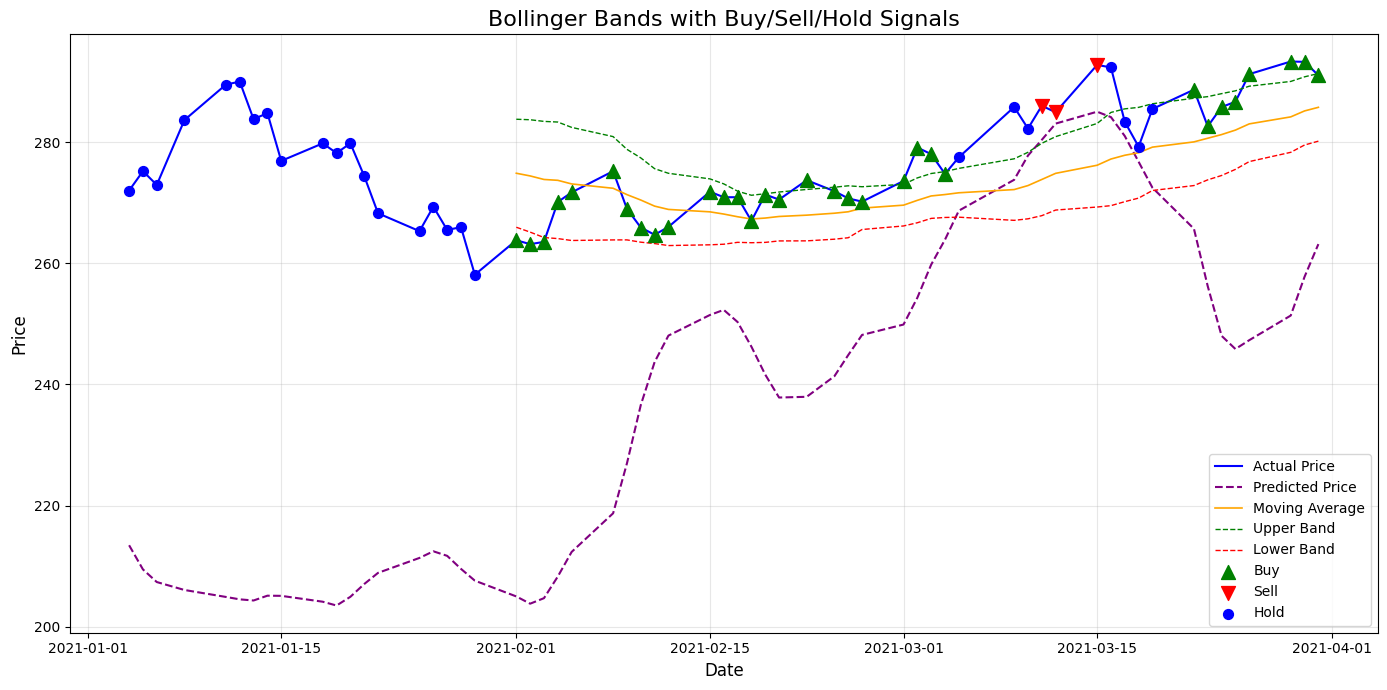


Decisions for Russia - Sberbank Rossii PAO (S: ['HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'HOLD', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'HOLD', 'HOLD', 'HOLD', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL']
Final Portfolio Value for Russia - Sberbank Rossii PAO (S: $10525.77


In [77]:
company_name = 'Russia - Sberbank Rossii PAO (S'
df = sheets_dict[company_name]  # Extract data for each company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Define parameters
window_size = 30
prediction_horizon = 1 # Daily, Weekly, Monthly prediction by changing horizon(1, 5, 20 day)

# Select only data for 2021
df_2021 = cleaned_df['2021-01-01':'2021-03-31']

# Data for 2020
df_2020 = cleaned_df['2020-01-01':'2020-12-31']

# Predict using the LSTM model for 2021 data
predicted_prices_2021, train_losses, eval_losses = process_company(df_2020, window_size, prediction_horizon=prediction_horizon)
predicted_prices_2021 = predicted_prices_2021[-len(df_2021):]  # Take the last elements

cleaned_df['Predicted Price'] = np.nan

if len(predicted_prices_2021.shape) > 1:  # Multi-step horizon
    predicted_prices_2021_flattened = predicted_prices_2021[:, 0]  # Use the first value of the horizon
else:
    predicted_prices_2021_flattened = predicted_prices_2021.flatten()

# Align predictions with the dataset
cleaned_df.iloc[-len(predicted_prices_2021_flattened):,
                cleaned_df.columns.get_loc('Predicted Price')] = predicted_prices_2021_flattened

# Slice the data for 2021
df_2021_with_predictions = cleaned_df['2021-01-01':'2021-03-31']

# Calculate Bollinger Bands for 2021 data
bollinger_df_2021 = calculate_bollinger_bands(df_2021_with_predictions['Price'])

# Classify decisions for 2021 data
decisions_2021 = classify_decisions(predicted_prices_2021, bollinger_df_2021)

# Extract historical prices and actual prices for evaluation
historical_prices = df_2020['Price']
actual_prices = df_2021['Price']

# Perform enhanced post-processing
decisions, final_portfolio_value, bollinger_df = enhanced_postprocessing(
    predicted_prices=predicted_prices_2021,
    actual_prices=actual_prices.values,
    historical_prices=historical_prices,
    initial_capital=10000  # Starting capital
)

# Pass the updated dataset to the plot function
plot_bollinger_bands(
    prices=df_2021_with_predictions['Price'],
    bollinger_df=bollinger_df_2021,
    decisions=decisions_2021,
    predicted_prices=df_2021_with_predictions['Predicted Price']
)

# Print decisions and final portfolio value
print(f"\nDecisions for {company_name}: {decisions}")
print(f"Final Portfolio Value for {company_name}: ${final_portfolio_value:.2f}")

In [75]:
df_2021_with_predictions[0:10]

,Price,Open,High,Low,Vol.,Change %,Predicted Price
Date,,,,,,,
2021-01-04,272.00,274.67,276.60,270.61,48920000.0,0.0013,215.302628
2021-01-05,275.20,272.69,275.70,270.28,45580000.0,0.0118,211.473602
2021-01-06,272.93,275.94,275.94,271.62,40950000.0,-0.0082,209.283524
2021-01-08,283.64,275.11,283.99,275.11,88930000.0,0.0392,208.084320
2021-01-11,289.49,282.86,292.95,279.48,112350000.0,0.0206,207.313950
2021-01-12,289.99,290.88,296.07,286.70,78960000.0,0.0017,207.243668
2021-01-13,283.78,291.01,292.46,283.10,67560000.0,-0.0214,207.377563
2021-01-14,284.79,284.00,286.90,279.06,74670000.0,0.0036,208.224640
2021-01-15,276.90,282.55,286.16,276.00,73770000.0,-0.0277,208.438797


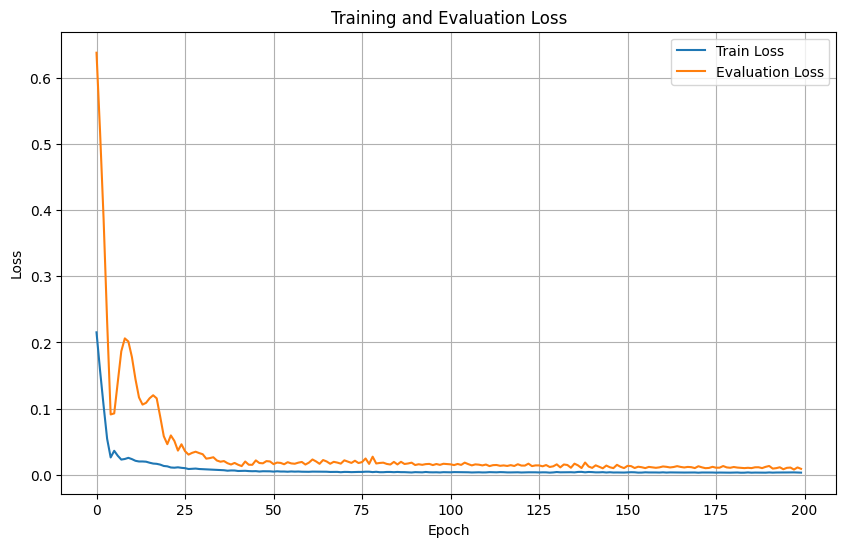

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Turkey - Koc Holding AS

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     315 non-null    float64
 1   Open      315 non-null    float64
 2   High      315 non-null    float64
 3   Low       315 non-null    float64
 4   Vol.      315 non-null    float64
 5   Change %  315 non-null    float64
dtypes: float64(6)
memory usage: 17.2 KB
            Price   Open   High    Low        Vol.  Change %
Date                                                        
2021-03-25  20.02  20.50  20.86  20.02  15930000.0   -0.0148
2021-03-26  19.25  20.28  20.36  19.10  21350000.0   -0.0385
2021-03-29  19.10  19.24  19.67  19.10  16560000.0   -0.0078
2021-03-30  19.50  19.12  19.81  19.03  21050000.0    0.0209
2021-03-31  19.41  19.42  19.63  19.27  13140000.0   -0.0046
window_size: 35, prediction_horizon: 1
prices type: <class 'numpy.ndarray'>, prices length: 252
E

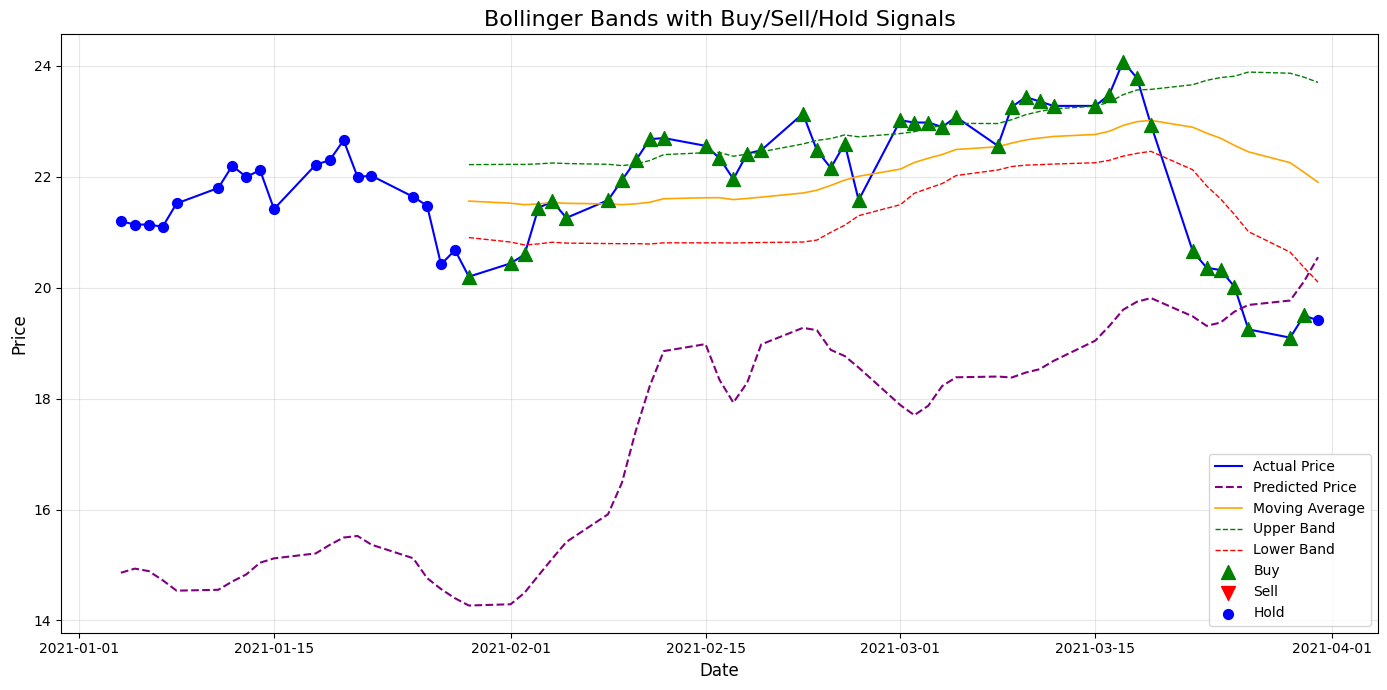


Decisions for Turkey - Koc Holding AS (KCHOL): ['HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL']
Final Portfolio Value for Turkey - Koc Holding AS (KCHOL): $11920.60


In [79]:
company_name = 'Turkey - Koc Holding AS (KCHOL)'
df = sheets_dict[company_name]  # Extract data for different company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Define parameters
window_size = 35
prediction_horizon = 1 # Daily, Weekly, Monthly prediction by changing horizon(1, 5, 20 day)

# Select only data for 2021
df_2021 = cleaned_df['2021-01-01':'2021-03-31']

# Data for 2020
df_2020 = cleaned_df['2020-01-01':'2020-12-31']

# Predict using the LSTM model for 2021 data
predicted_prices_2021, train_losses, eval_losses = process_company(df_2020, window_size, prediction_horizon=prediction_horizon)

predicted_prices_2021 = predicted_prices_2021[-len(df_2021):]  # Take the last elements

cleaned_df['Predicted Price'] = np.nan

if len(predicted_prices_2021.shape) > 1:  # Multi-step horizon
    predicted_prices_2021_flattened = predicted_prices_2021[:, 0]  # Use the first value of the horizon
else:
    predicted_prices_2021_flattened = predicted_prices_2021.flatten()

# Align predictions with the dataset
cleaned_df.iloc[-len(predicted_prices_2021_flattened):, cleaned_df.columns.get_loc('Predicted Price')] = predicted_prices_2021_flattened

# Slice the data for 2021
df_2021_with_predictions = cleaned_df['2021-01-01':'2021-03-31']

# Calculate Bollinger Bands for 2021 data
bollinger_df_2021 = calculate_bollinger_bands(df_2021_with_predictions['Price'])

# Classify decisions for 2021 data
decisions_2021 = classify_decisions(predicted_prices_2021, bollinger_df_2021)

# Extract historical prices and actual prices for evaluation
historical_prices = df_2020['Price']
actual_prices = df_2021['Price']

# Perform enhanced post-processing
decisions, final_portfolio_value, bollinger_df = enhanced_postprocessing(
    predicted_prices=predicted_prices_2021,
    actual_prices=actual_prices.values,
    historical_prices=historical_prices,
    initial_capital=10000  # Starting capital
)

# Pass the updated dataset to the plot function
plot_bollinger_bands(
    prices=df_2021_with_predictions['Price'],
    bollinger_df=bollinger_df_2021,
    decisions=decisions_2021,
    predicted_prices=df_2021_with_predictions['Predicted Price']
)

# Print decisions and final portfolio value
print(f"\nDecisions for {company_name}: {decisions}")
print(f"Final Portfolio Value for {company_name}: ${final_portfolio_value:.2f}")

In [20]:
df_2021_with_predictions[0:10]

,Price,Open,High,Low,Vol.,Change %,Predicted Price
Date,,,,,,,
2021-01-04,21.20,21.12,21.50,21.04,10530000.0,0.0038,14.738736
2021-01-05,21.14,21.00,21.60,20.86,15650000.0,-0.0028,14.821278
2021-01-06,21.14,21.24,21.34,20.86,12230000.0,0.0000,14.868768
2021-01-07,21.10,21.20,21.26,20.88,7910000.0,-0.0019,14.864015
2021-01-08,21.52,21.22,21.52,21.12,10360000.0,0.0199,14.818377
2021-01-11,21.80,21.48,22.12,21.34,20000000.0,0.0130,14.798530
2021-01-12,22.20,21.84,22.24,21.72,10100000.0,0.0183,14.810598
2021-01-13,22.00,22.26,22.40,21.86,6960000.0,-0.0090,14.832623
2021-01-14,22.12,22.10,22.18,21.84,6750000.0,0.0055,14.902944


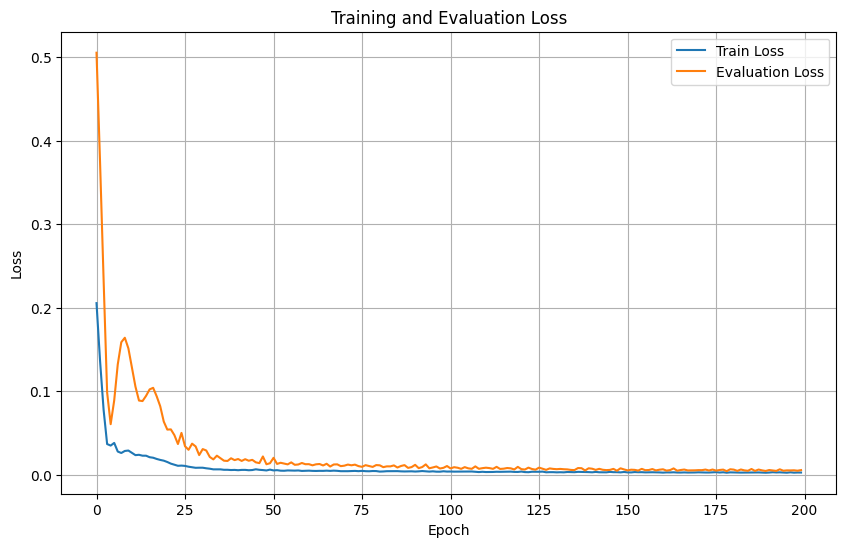

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Egypt - Medinet Nasr Housing

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 305 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     305 non-null    float64
 1   Open      305 non-null    float64
 2   High      305 non-null    float64
 3   Low       305 non-null    float64
 4   Vol.      305 non-null    float64
 5   Change %  305 non-null    float64
dtypes: float64(6)
memory usage: 16.7 KB
            Price  Open  High   Low       Vol.  Change %
Date                                                    
2021-03-25   3.71  3.62  3.78  3.59  2500000.0    0.0137
2021-03-28   3.71  3.76  3.76  3.68  2340000.0    0.0000
2021-03-29   3.70  3.69  3.73  3.68  1250000.0   -0.0027
2021-03-30   3.73  3.71  3.76  3.67  3430000.0    0.0081
2021-03-31   3.75  3.74  3.82  3.71  1570000.0    0.0054
window_size: 30, prediction_horizon: 5
prices type: <class 'numpy.ndarray'>, prices length: 243
Epoch 1/100, Train Loss: 0.11

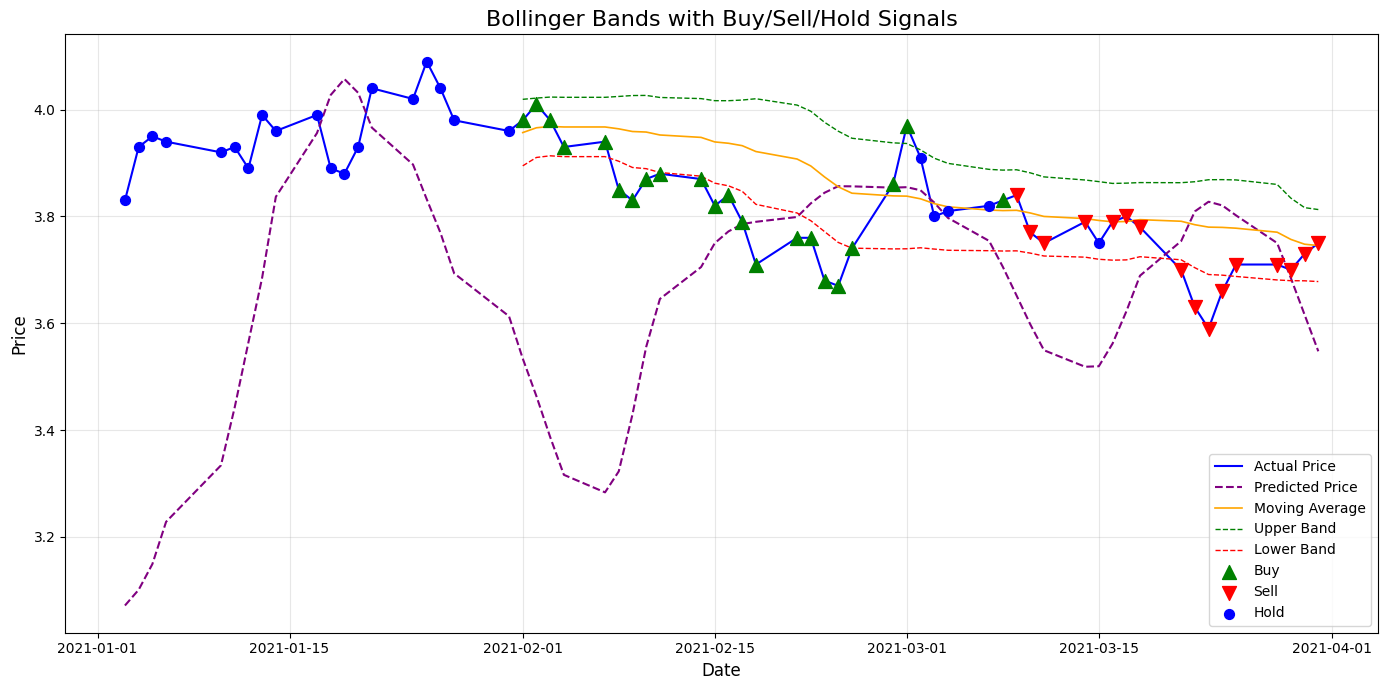


Decisions for Egypt - Medinet Nasr Housing (M: ['HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'S

In [22]:
company_name = 'Egypt - Medinet Nasr Housing (M'
df = sheets_dict[company_name]  # Extract data for different company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Define parameters
window_size = 30
prediction_horizon = 5 # Daily, Weekly, Monthly prediction by changing horizon(1, 5, 20 day)

# Select only data for 2021
df_2021 = cleaned_df['2021-01-01':'2021-03-31']

# Data for 2020
df_2020 = cleaned_df['2020-01-01':'2020-12-31']

# Predict using the LSTM model for 2021 data
predicted_prices_2021, train_losses, eval_losses = process_company(df_2020, window_size, prediction_horizon=prediction_horizon)

predicted_prices_2021 = predicted_prices_2021[-len(df_2021):]  # Take the last elements

cleaned_df['Predicted Price'] = np.nan

if len(predicted_prices_2021.shape) > 1:  # Multi-step horizon
    predicted_prices_2021_flattened = predicted_prices_2021[:, 0]  # Use the first value of the horizon
else:
    predicted_prices_2021_flattened = predicted_prices_2021.flatten()

# Align predictions with the dataset
cleaned_df.iloc[-len(predicted_prices_2021_flattened):, cleaned_df.columns.get_loc('Predicted Price')] = predicted_prices_2021_flattened

# Slice the data for 2021
df_2021_with_predictions = cleaned_df['2021-01-01':'2021-03-31']

# Calculate Bollinger Bands for 2021 data
bollinger_df_2021 = calculate_bollinger_bands(df_2021_with_predictions['Price'])

# Classify decisions for 2021 data
decisions_2021 = classify_decisions(predicted_prices_2021, bollinger_df_2021)

# Extract historical prices and actual prices for evaluation
historical_prices = df_2020['Price']
actual_prices = df_2021['Price']

# Perform enhanced post-processing
decisions, final_portfolio_value, bollinger_df = enhanced_postprocessing(
    predicted_prices=predicted_prices_2021,
    actual_prices=actual_prices.values,
    historical_prices=historical_prices,
    initial_capital=10000  # Starting capital
)

# Pass the updated dataset to the plot function
plot_bollinger_bands(
    prices=df_2021_with_predictions['Price'],
    bollinger_df=bollinger_df_2021,
    decisions=decisions_2021,
    predicted_prices=df_2021_with_predictions['Predicted Price']
)

# Print decisions and final portfolio value
print(f"\nDecisions for {company_name}: {decisions}")
print(f"Final Portfolio Value for {company_name}: ${final_portfolio_value:.2f}")


In [23]:
df_2021_with_predictions[0:10]

,Price,Open,High,Low,Vol.,Change %,Predicted Price
Date,,,,,,,
2021-01-03,3.83,3.79,3.87,3.79,3570000.0,0.0026,3.071628
2021-01-04,3.93,3.85,3.98,3.85,14770000.0,0.0261,3.101101
2021-01-05,3.95,3.99,3.99,3.91,4390000.0,0.0051,3.149245
2021-01-06,3.94,3.95,4.00,3.90,5850000.0,-0.0025,3.228363
2021-01-10,3.92,3.99,3.99,3.89,3360000.0,-0.0051,3.334024
2021-01-11,3.93,3.93,3.95,3.90,3030000.0,0.0026,3.442459
2021-01-12,3.89,3.91,3.93,3.86,2040000.0,-0.0102,3.564067
2021-01-13,3.99,3.90,4.04,3.90,10590000.0,0.0257,3.685048
2021-01-14,3.96,3.98,4.00,3.94,5420000.0,-0.0075,3.836718


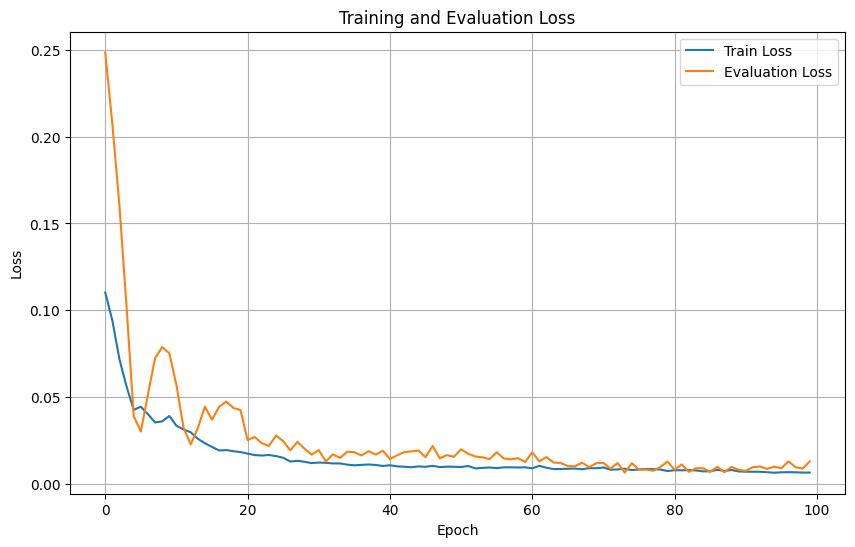

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Brazil - Minerva SABrazil

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 309 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     309 non-null    float64
 1   Open      309 non-null    float64
 2   High      309 non-null    float64
 3   Low       309 non-null    float64
 4   Vol.      309 non-null    float64
 5   Change %  309 non-null    float64
dtypes: float64(6)
memory usage: 16.9 KB
            Price   Open   High    Low        Vol.  Change %
Date                                                        
2021-03-25   9.80  10.01  10.01   9.66   8880000.0   -0.0151
2021-03-26   9.83   9.80   9.94   9.70   5110000.0    0.0031
2021-03-29  10.47   9.85  10.50   9.81  22040000.0    0.0651
2021-03-30  10.36  10.41  10.62  10.30   9930000.0   -0.0105
2021-03-31  10.20  10.35  10.40  10.12   7770000.0   -0.0154
window_size: 30, prediction_horizon: 5
prices type: <class 'numpy.ndarray'>, prices length: 249
E

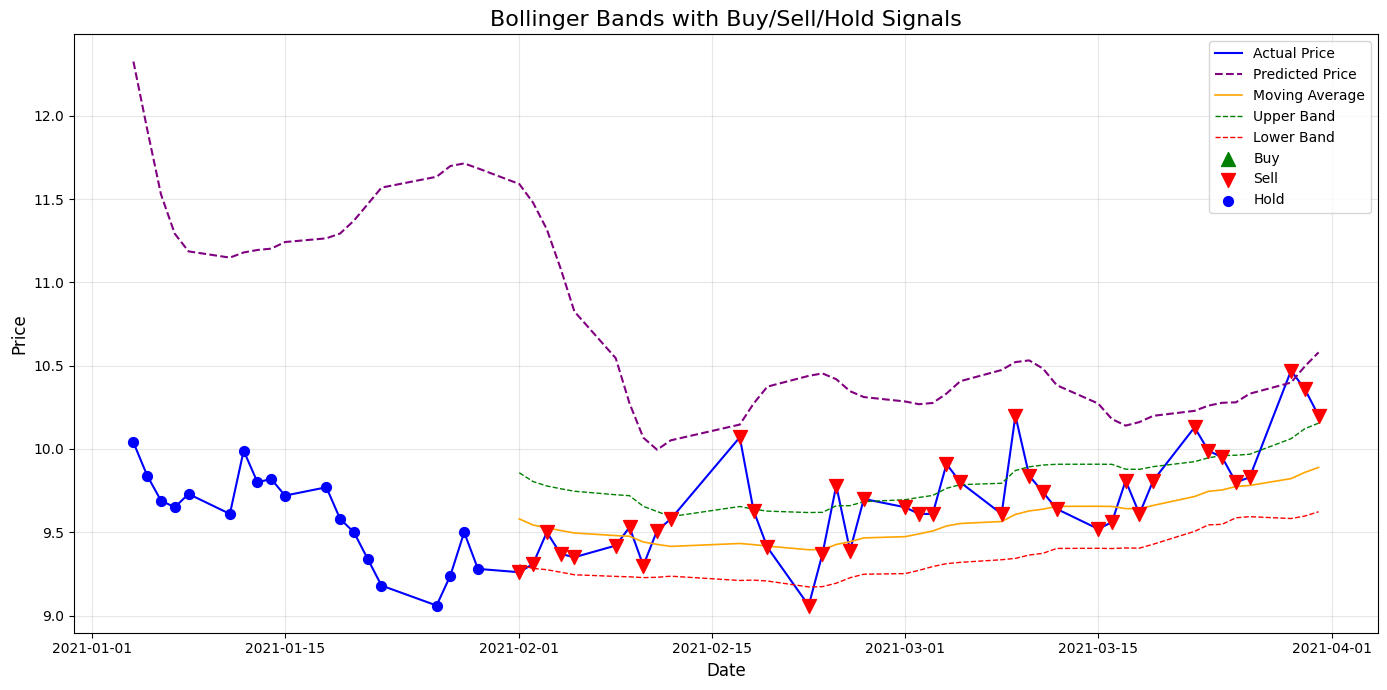


Decisions for Brazil - Minerva SABrazil (BEEF: ['HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'HOLD', 'HOLD', 'HOLD', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'B

In [28]:
company_name = 'Brazil - Minerva SABrazil (BEEF'
df = sheets_dict[company_name]  # Extract data for different company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Define parameters
window_size = 30
prediction_horizon = 5 # Daily, Weekly, Monthly prediction by changing horizon(1, 5, 20 day)

# Select only data for 2021
df_2021 = cleaned_df['2021-01-01':'2021-03-31']

# Data for 2020
df_2020 = cleaned_df['2020-01-01':'2020-12-31']

# Predict using the LSTM model for 2021 data
predicted_prices_2021, train_losses, eval_losses = process_company(df_2020, window_size, prediction_horizon=prediction_horizon)

predicted_prices_2021 = predicted_prices_2021[-len(df_2021):]  # Take the last elements

cleaned_df['Predicted Price'] = np.nan

if len(predicted_prices_2021.shape) > 1:  # Multi-step horizon
    predicted_prices_2021_flattened = predicted_prices_2021[:, 0]  # Use the first value of the horizon
else:
    predicted_prices_2021_flattened = predicted_prices_2021.flatten()

# Align predictions with the dataset
cleaned_df.iloc[-len(predicted_prices_2021_flattened):, cleaned_df.columns.get_loc('Predicted Price')] = predicted_prices_2021_flattened

# Slice the data for 2021
df_2021_with_predictions = cleaned_df['2021-01-01':'2021-03-31']

# Calculate Bollinger Bands for 2021 data
bollinger_df_2021 = calculate_bollinger_bands(df_2021_with_predictions['Price'])

# Classify decisions for 2021 data
decisions_2021 = classify_decisions(predicted_prices_2021, bollinger_df_2021)

# Extract historical prices and actual prices for evaluation
historical_prices = df_2020['Price']
actual_prices = df_2021['Price']

# Perform enhanced post-processing
decisions, final_portfolio_value, bollinger_df = enhanced_postprocessing(
    predicted_prices=predicted_prices_2021,
    actual_prices=actual_prices.values,
    historical_prices=historical_prices,
    initial_capital=10000  # Starting capital
)

# Pass the updated dataset to the plot function
plot_bollinger_bands(
    prices=df_2021_with_predictions['Price'],
    bollinger_df=bollinger_df_2021,
    decisions=decisions_2021,
    predicted_prices=df_2021_with_predictions['Predicted Price']
)

# Print decisions and final portfolio value
print(f"\nDecisions for {company_name}: {decisions}")
print(f"Final Portfolio Value for {company_name}: ${final_portfolio_value:.2f}")


In [29]:
df_2021_with_predictions[0:10]

,Price,Open,High,Low,Vol.,Change %,Predicted Price
Date,,,,,,,
2021-01-04,10.04,10.23,10.32,10.03,6120000.0,-0.0138,12.326380
2021-01-05,9.84,10.07,10.10,9.77,13660000.0,-0.0199,11.919660
2021-01-06,9.69,9.85,9.86,9.69,8360000.0,-0.0152,11.529026
2021-01-07,9.65,9.75,9.81,9.62,7770000.0,-0.0041,11.292663
2021-01-08,9.73,9.67,9.85,9.66,7460000.0,0.0083,11.186449
2021-01-11,9.61,9.70,9.80,9.60,10900000.0,-0.0123,11.148965
2021-01-12,9.99,9.68,10.03,9.62,14240000.0,0.0395,11.179895
2021-01-13,9.80,10.05,10.06,9.68,11380000.0,-0.0190,11.194789
2021-01-14,9.82,9.86,9.96,9.73,7000000.0,0.0020,11.202963


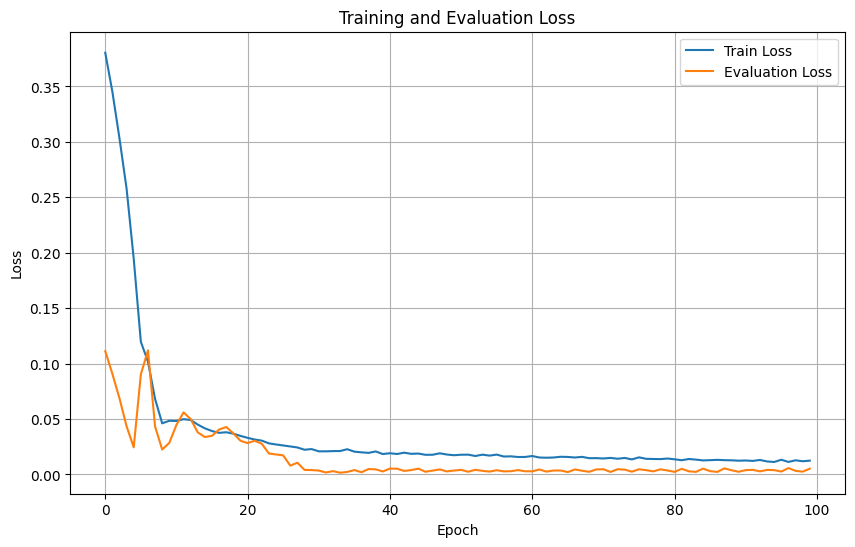

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Argentina - Pampa Energia SA

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     300 non-null    float64
 1   Open      300 non-null    float64
 2   High      300 non-null    float64
 3   Low       300 non-null    float64
 4   Vol.      300 non-null    float64
 5   Change %  300 non-null    float64
dtypes: float64(6)
memory usage: 16.4 KB
            Price   Open   High    Low      Vol.  Change %
Date                                                      
2021-03-25  83.60  85.20  87.30  82.10  389780.0   -0.0313
2021-03-26  81.85  84.00  84.60  80.70  462550.0   -0.0209
2021-03-29  85.00  80.00  86.00  79.00  371220.0    0.0385
2021-03-30  86.10  85.15  86.75  84.60  141400.0    0.0129
2021-03-31  85.15  86.50  88.10  85.15  564300.0   -0.0110
window_size: 25, prediction_horizon: 1
prices type: <class 'numpy.ndarray'>, prices length: 240
Epoch 1/200, Tr

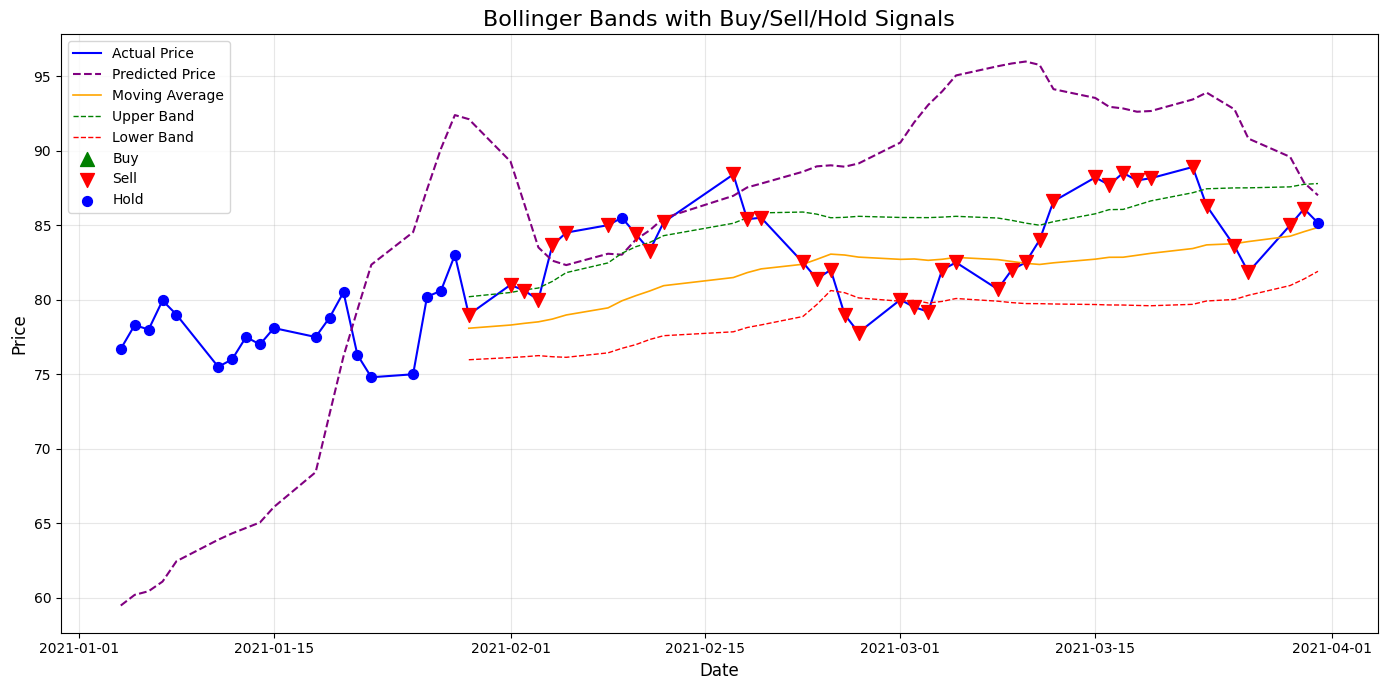


Decisions for Argentina - Pampa Energia SA (P: ['HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL']
Final Portfolio Value for Argentina - Pampa Energia SA (P: $10000.00


In [40]:
company_name = 'Argentina - Pampa Energia SA (P'
df = sheets_dict[company_name]  # Extract data for different company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Define parameters
window_size = 25
prediction_horizon = 1 # Daily, Weekly, Monthly prediction by changing horizon(1, 5, 20 day)

# Select only data for 2021
df_2021 = cleaned_df['2021-01-01':'2021-03-31']

# Data for 2020
df_2020 = cleaned_df['2020-01-01':'2020-12-31']

# Predict using the LSTM model for 2021 data
predicted_prices_2021, train_losses, eval_losses = process_company(df_2020, window_size, prediction_horizon=prediction_horizon)

predicted_prices_2021 = predicted_prices_2021[-len(df_2021):]  # Take the last elements

cleaned_df['Predicted Price'] = np.nan

if len(predicted_prices_2021.shape) > 1:  # Multi-step horizon
    predicted_prices_2021_flattened = predicted_prices_2021[:, 0]  # Use the first value of the horizon
else:
    predicted_prices_2021_flattened = predicted_prices_2021.flatten()

# Align predictions with the dataset
cleaned_df.iloc[-len(predicted_prices_2021_flattened):, cleaned_df.columns.get_loc('Predicted Price')] = predicted_prices_2021_flattened

# Slice the data for 2021
df_2021_with_predictions = cleaned_df['2021-01-01':'2021-03-31']

# Calculate Bollinger Bands for 2021 data
bollinger_df_2021 = calculate_bollinger_bands(df_2021_with_predictions['Price'])

# Classify decisions for 2021 data
decisions_2021 = classify_decisions(predicted_prices_2021, bollinger_df_2021)

# Extract historical prices and actual prices for evaluation
historical_prices = df_2020['Price']
actual_prices = df_2021['Price']

# Perform enhanced post-processing
decisions, final_portfolio_value, bollinger_df = enhanced_postprocessing(
    predicted_prices=predicted_prices_2021,
    actual_prices=actual_prices.values,
    historical_prices=historical_prices,
    initial_capital=10000  # Starting capital
)

# Pass the updated dataset to the plot function
plot_bollinger_bands(
    prices=df_2021_with_predictions['Price'],
    bollinger_df=bollinger_df_2021,
    decisions=decisions_2021,
    predicted_prices=df_2021_with_predictions['Predicted Price']
)

# Print decisions and final portfolio value
print(f"\nDecisions for {company_name}: {decisions}")
print(f"Final Portfolio Value for {company_name}: ${final_portfolio_value:.2f}")


In [41]:
df_2021_with_predictions[0:10]

,Price,Open,High,Low,Vol.,Change %,Predicted Price
Date,,,,,,,
2021-01-04,76.70,76.90,78.1,76.0,463280.0,-0.0026,59.493248
2021-01-05,78.30,76.65,78.9,76.2,500060.0,0.0209,60.208603
2021-01-06,78.00,77.60,78.9,77.0,175530.0,-0.0038,60.453568
2021-01-07,79.95,76.60,80.4,76.6,414260.0,0.0250,61.098888
2021-01-08,79.00,79.45,79.9,76.3,836370.0,-0.0119,62.463676
2021-01-11,75.50,76.70,77.2,73.8,251450.0,-0.0443,63.905350
2021-01-12,76.00,74.55,78.0,73.2,436600.0,0.0066,64.331680
2021-01-13,77.50,76.05,78.0,75.5,253170.0,0.0197,64.696938
2021-01-14,77.00,78.00,78.5,75.8,741080.0,-0.0065,65.064400


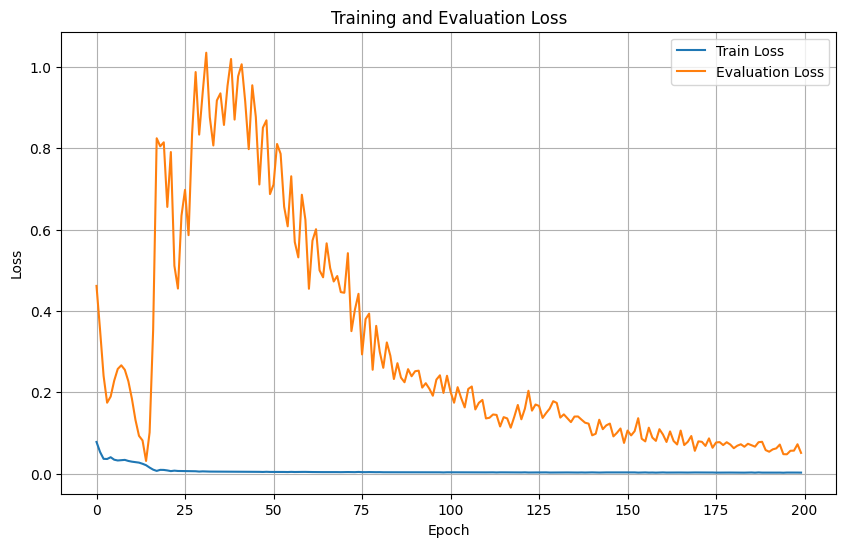

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Colombia - Cementos Argos SA

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 303 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     303 non-null    float64
 1   Open      303 non-null    float64
 2   High      303 non-null    float64
 3   Low       303 non-null    float64
 4   Vol.      303 non-null    float64
 5   Change %  303 non-null    float64
dtypes: float64(6)
memory usage: 16.6 KB
             Price    Open    High     Low      Vol.  Change %
Date                                                          
2021-03-25  5030.0  5035.0  5045.0  4950.0  317060.0    0.0010
2021-03-26  5020.0  5085.0  5085.0  4980.0  203460.0   -0.0020
2021-03-29  5045.0  5020.0  5045.0  5015.0  117540.0    0.0050
2021-03-30  5100.0  5010.0  5100.0  5010.0  583700.0    0.0109
2021-03-31  5150.0  5100.0  5170.0  5100.0  212440.0    0.0098
window_size: 30, prediction_horizon: 20
prices type: <class 'numpy.ndarray'>, price

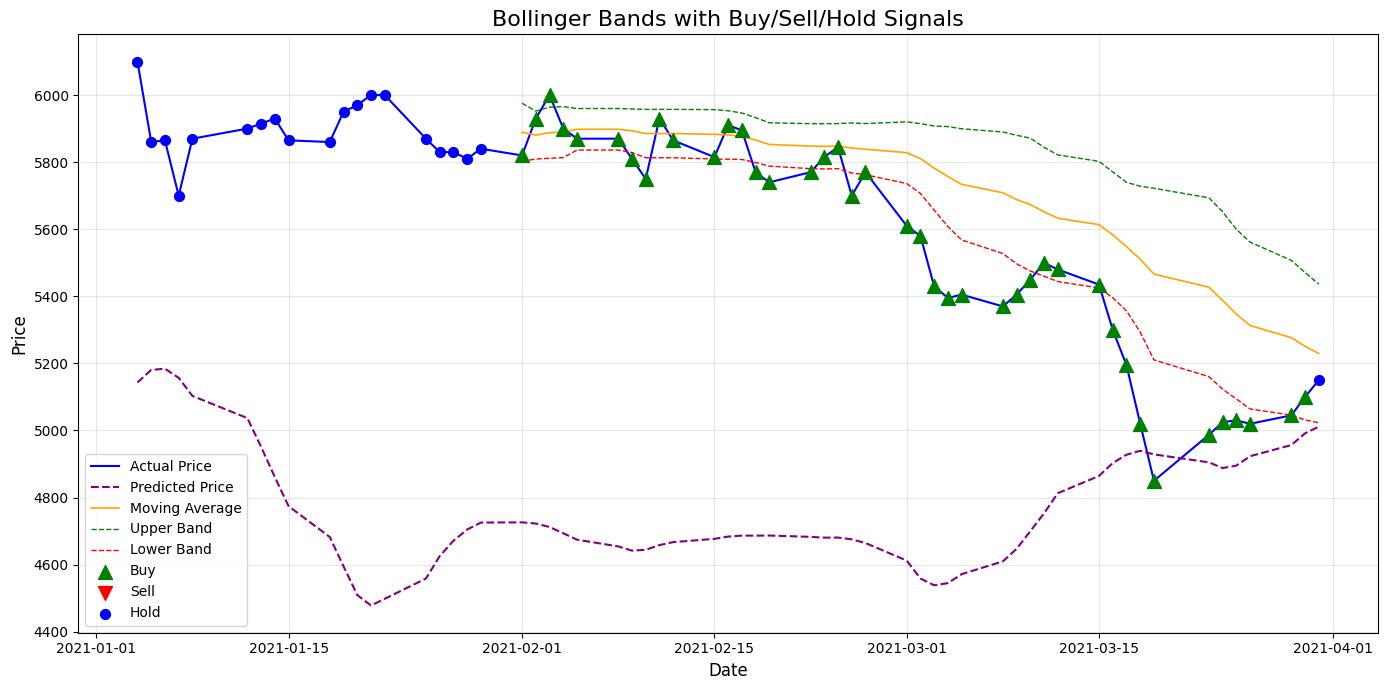


Decisions for Colombia - Cementos Argos SA (C: ['HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL

In [50]:
company_name = 'Colombia - Cementos Argos SA (C'
df = sheets_dict[company_name]  # Extract data for different company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Define parameters
window_size = 30
prediction_horizon = 20 # Daily, Weekly, Monthly prediction by changing horizon(1, 5, 20 day)

# Select only data for 2021
df_2021 = cleaned_df['2021-01-01':'2021-03-31']

# Data for 2020
df_2020 = cleaned_df['2020-01-01':'2020-12-31']

# Predict using the LSTM model for 2021 data
predicted_prices_2021, train_losses, eval_losses = process_company(df_2020, window_size, prediction_horizon=prediction_horizon)

predicted_prices_2021 = predicted_prices_2021[-len(df_2021):]  # Take the last elements

cleaned_df['Predicted Price'] = np.nan

if len(predicted_prices_2021.shape) > 1:  # Multi-step horizon
    predicted_prices_2021_flattened = predicted_prices_2021[:, 0]  # Use the first value of the horizon
else:
    predicted_prices_2021_flattened = predicted_prices_2021.flatten()

# Align predictions with the dataset
cleaned_df.iloc[-len(predicted_prices_2021_flattened):, cleaned_df.columns.get_loc('Predicted Price')] = predicted_prices_2021_flattened

# Slice the data for 2021
df_2021_with_predictions = cleaned_df['2021-01-01':'2021-03-31']

# Calculate Bollinger Bands for 2021 data
bollinger_df_2021 = calculate_bollinger_bands(df_2021_with_predictions['Price'])

# Classify decisions for 2021 data
decisions_2021 = classify_decisions(predicted_prices_2021, bollinger_df_2021)

# Extract historical prices and actual prices for evaluation
historical_prices = df_2020['Price']
actual_prices = df_2021['Price']

# Perform enhanced post-processing
decisions, final_portfolio_value, bollinger_df = enhanced_postprocessing(
    predicted_prices=predicted_prices_2021,
    actual_prices=actual_prices.values,
    historical_prices=historical_prices,
    initial_capital=10000  # Starting capital
)

# Pass the updated dataset to the plot function
plot_bollinger_bands(
    prices=df_2021_with_predictions['Price'],
    bollinger_df=bollinger_df_2021,
    decisions=decisions_2021,
    predicted_prices=df_2021_with_predictions['Predicted Price']
)

# Print decisions and final portfolio value
print(f"\nDecisions for {company_name}: {decisions}")
print(f"Final Portfolio Value for {company_name}: ${final_portfolio_value:.2f}")


In [48]:
df_2021_with_predictions[0:10]

,Price,Open,High,Low,Vol.,Change %,Predicted Price
Date,,,,,,,
2021-01-04,6100.0,6110.0,6160.0,5900.0,454990.0,-0.0129,4725.889648
2021-01-05,5860.0,6000.0,6000.0,5860.0,457030.0,-0.0393,4714.206055
2021-01-06,5865.0,5860.0,5955.0,5860.0,338980.0,0.0009,4699.672363
2021-01-07,5700.0,5860.0,5985.0,5700.0,539180.0,-0.0281,4673.030273
2021-01-08,5870.0,5805.0,5870.0,5790.0,154800.0,0.0298,4644.867676
2021-01-12,5900.0,5895.0,5950.0,5850.0,404930.0,0.0051,4611.623535
2021-01-13,5915.0,5910.0,5920.0,5870.0,431280.0,0.0025,4588.622559
2021-01-14,5930.0,5910.0,6000.0,5900.0,450710.0,0.0025,4589.484375
2021-01-15,5865.0,5980.0,5980.0,5865.0,208320.0,-0.0110,4605.303223


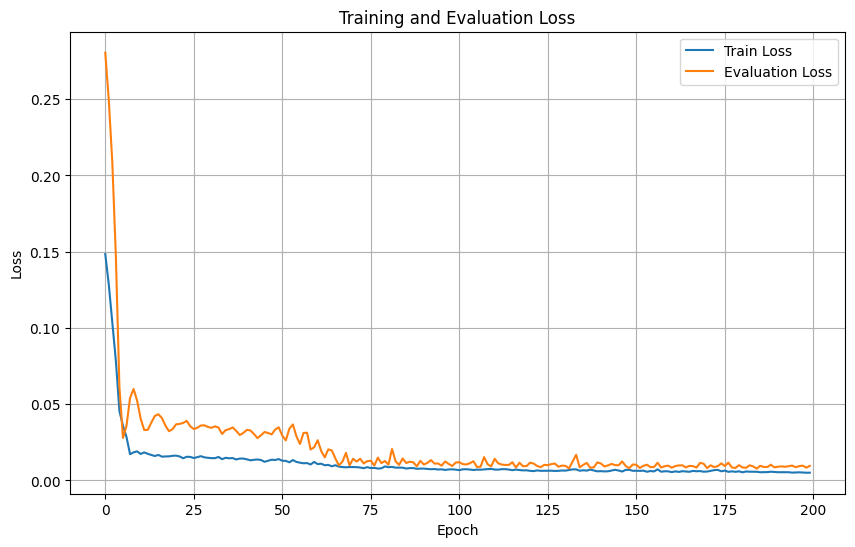

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

## South Africa - Impala Platinum

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 314 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     314 non-null    float64
 1   Open      314 non-null    float64
 2   High      314 non-null    float64
 3   Low       314 non-null    float64
 4   Vol.      314 non-null    float64
 5   Change %  314 non-null    float64
dtypes: float64(6)
memory usage: 17.2 KB
              Price     Open     High      Low       Vol.  Change %
Date                                                               
2021-03-25  26564.0  25954.0  27128.0  25954.0  2830000.0    0.0255
2021-03-26  27533.0  27083.0  28006.0  26728.0  3360000.0    0.0365
2021-03-29  26980.0  27800.0  28174.0  26614.0  4440000.0   -0.0201
2021-03-30  26898.0  26766.0  27443.0  26360.0  3020000.0   -0.0030
2021-03-31  27373.0  26980.0  27526.0  26657.0  2490000.0    0.0177
window_size: 30, prediction_horizon: 5
prices ty

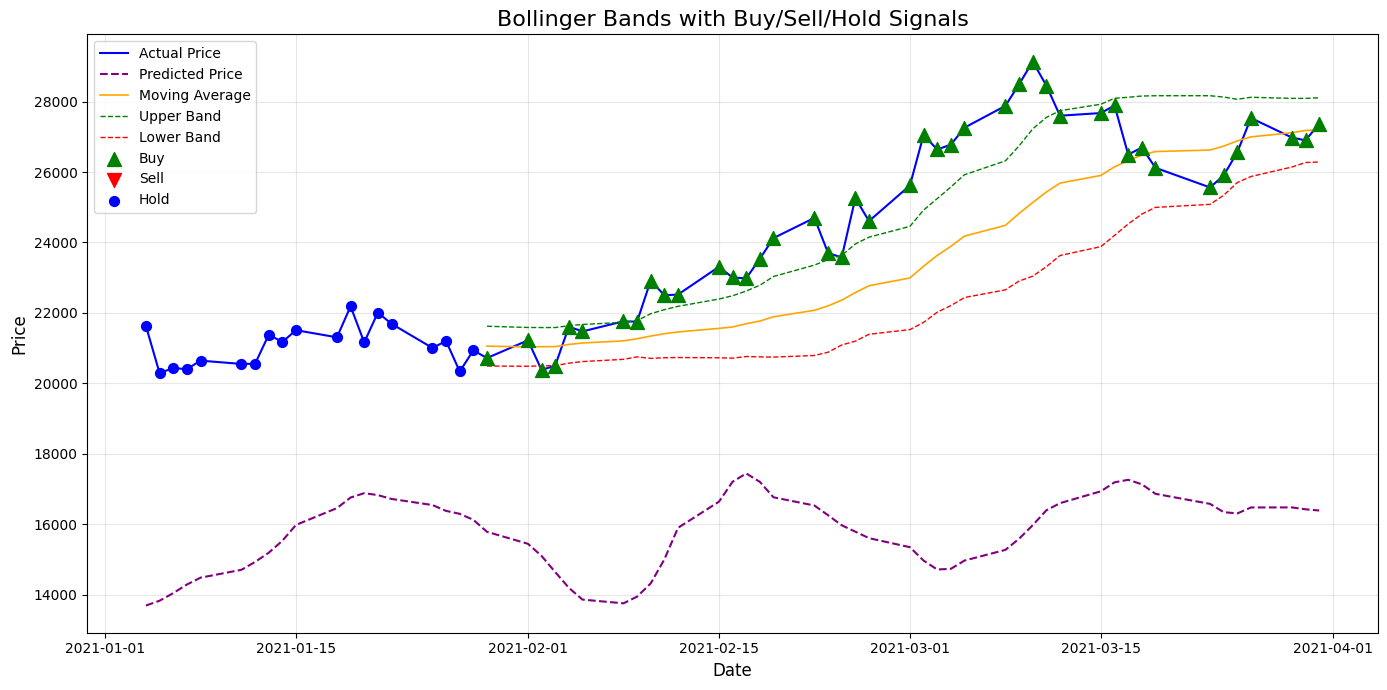


Decisions for South Africa - Impala Platinum : ['HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'BUY', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 

In [56]:
company_name = 'South Africa - Impala Platinum '
df = sheets_dict[company_name]  # Extract data for different company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Define parameters
window_size = 30
prediction_horizon = 5 # Daily, Weekly, Monthly prediction by changing horizon(1, 5, 20 day)

# Select only data for 2021
df_2021 = cleaned_df['2021-01-01':'2021-03-31']

# Data for 2020
df_2020 = cleaned_df['2020-01-01':'2020-12-31']

# Predict using the LSTM model for 2021 data
predicted_prices_2021, train_losses, eval_losses = process_company(df_2020, window_size, prediction_horizon=prediction_horizon)

predicted_prices_2021 = predicted_prices_2021[-len(df_2021):]  # Take the last elements

cleaned_df['Predicted Price'] = np.nan

if len(predicted_prices_2021.shape) > 1:  # Multi-step horizon
    predicted_prices_2021_flattened = predicted_prices_2021[:, 0]  # Use the first value of the horizon
else:
    predicted_prices_2021_flattened = predicted_prices_2021.flatten()

# Align predictions with the dataset
cleaned_df.iloc[-len(predicted_prices_2021_flattened):, cleaned_df.columns.get_loc('Predicted Price')] = predicted_prices_2021_flattened

# Slice the data for 2021
df_2021_with_predictions = cleaned_df['2021-01-01':'2021-03-31']

# Calculate Bollinger Bands for 2021 data
bollinger_df_2021 = calculate_bollinger_bands(df_2021_with_predictions['Price'])

# Classify decisions for 2021 data
decisions_2021 = classify_decisions(predicted_prices_2021, bollinger_df_2021)

# Extract historical prices and actual prices for evaluation
historical_prices = df_2020['Price']
actual_prices = df_2021['Price']

# Perform enhanced post-processing
decisions, final_portfolio_value, bollinger_df = enhanced_postprocessing(
    predicted_prices=predicted_prices_2021,
    actual_prices=actual_prices.values,
    historical_prices=historical_prices,
    initial_capital=10000  # Starting capital
)

# Pass the updated dataset to the plot function
plot_bollinger_bands(
    prices=df_2021_with_predictions['Price'],
    bollinger_df=bollinger_df_2021,
    decisions=decisions_2021,
    predicted_prices=df_2021_with_predictions['Predicted Price']
)

# Print decisions and final portfolio value
print(f"\nDecisions for {company_name}: {decisions}")
print(f"Final Portfolio Value for {company_name}: ${final_portfolio_value:.2f}")


In [57]:
df_2021_with_predictions[0:10]

,Price,Open,High,Low,Vol.,Change %,Predicted Price
Date,,,,,,,
2021-01-04,21629.0,20451.0,21629.0,20420.0,1790000.0,0.0713,13689.415039
2021-01-05,20288.0,21575.0,21598.0,20147.0,3360000.0,-0.0620,13825.475586
2021-01-06,20436.0,20650.0,21181.0,20290.0,3000000.0,0.0073,14041.880859
2021-01-07,20400.0,20495.0,20982.0,20126.0,3050000.0,-0.0018,14285.429688
2021-01-08,20644.0,20400.0,21039.0,19700.0,3090000.0,0.0120,14479.974609
2021-01-11,20550.0,20618.0,20932.0,20059.0,2110000.0,-0.0046,14704.088867
2021-01-12,20555.0,20960.0,21300.0,20250.0,2590000.0,0.0002,14927.056641
2021-01-13,21379.0,20657.0,21638.0,20600.0,2680000.0,0.0401,15188.208984
2021-01-14,21175.0,21450.0,21690.0,20967.0,2080000.0,-0.0095,15528.940430


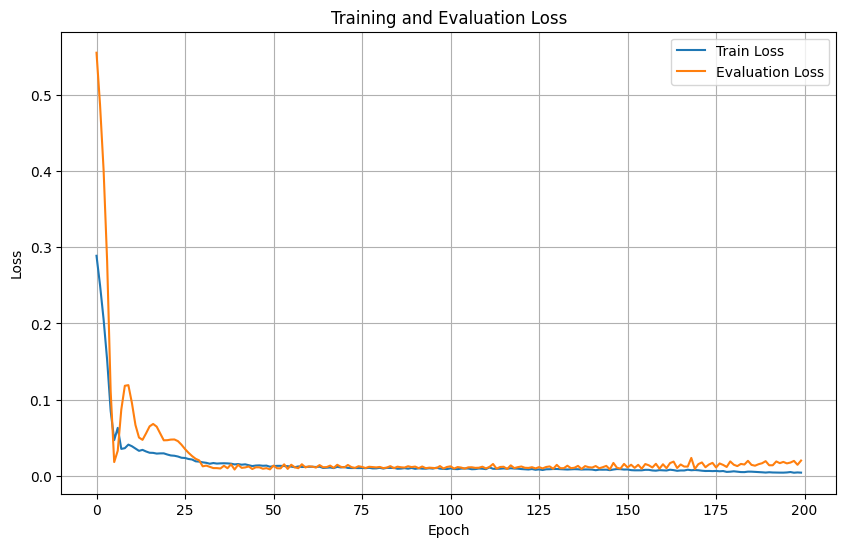

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

## South Korea - Dongkuk Steel

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 341 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     341 non-null    float64
 1   Open      341 non-null    float64
 2   High      341 non-null    float64
 3   Low       341 non-null    float64
 4   Vol.      341 non-null    float64
 5   Change %  341 non-null    float64
dtypes: float64(6)
memory usage: 18.6 KB
              Price     Open     High      Low       Vol.  Change %
Date                                                               
2021-03-26  12200.0  11500.0  12300.0  11350.0  2340000.0    0.0796
2021-03-28  12200.0  12200.0  12200.0  12200.0        0.0    0.0000
2021-03-29  13550.0  12500.0  13800.0  12500.0      200.0    0.1107
2021-03-30  13650.0  13850.0  14200.0  13050.0  3170000.0    0.0074
2021-03-31  13650.0  13700.0  13750.0  13450.0      190.0    0.0000
window_size: 5, prediction_horizon: 1
prices typ

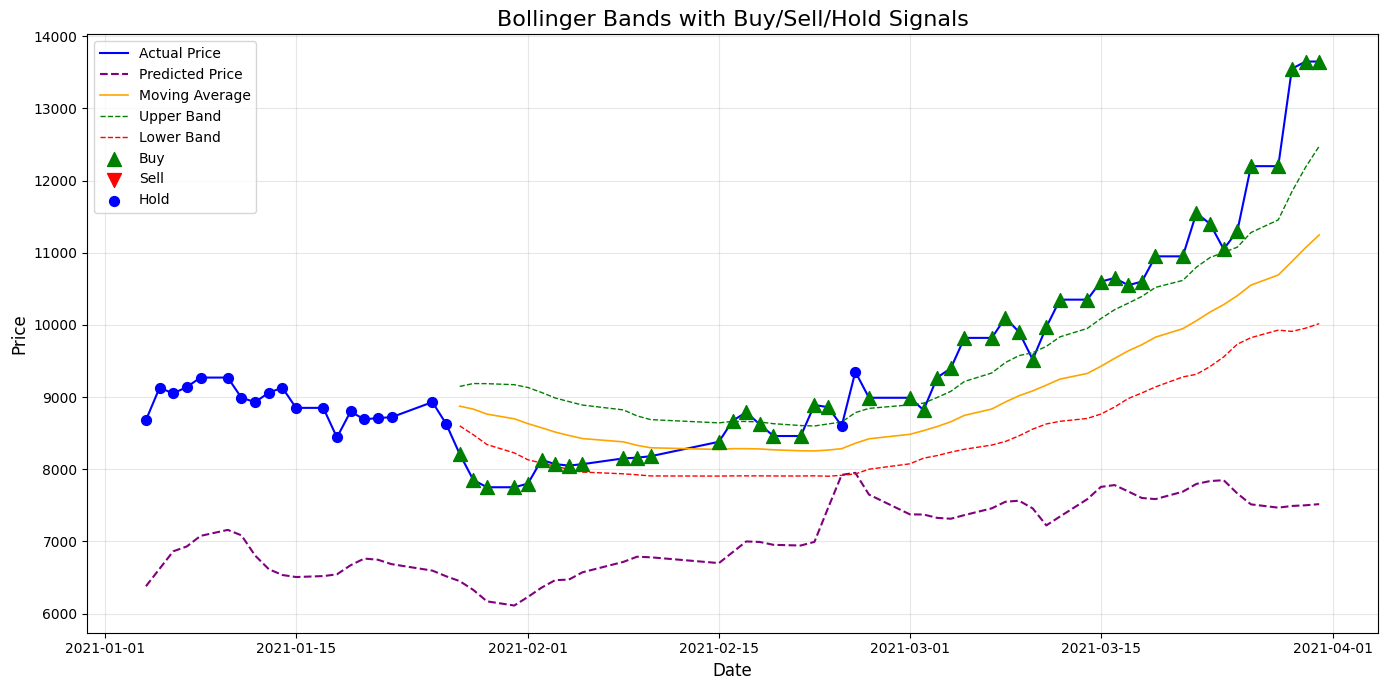


Decisions for South Korea - Dongkuk Steel Mil: ['HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL']
Final Portfolio Value for South Korea - Dongkuk Steel Mil: $10000.00


In [65]:
company_name = 'South Korea - Dongkuk Steel Mil'
df = sheets_dict[company_name]  # Extract data for different company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Define parameters
window_size = 5
prediction_horizon = 1 # Daily, Weekly, Monthly prediction by changing horizon(1, 5, 20 day)

# Select only data for 2021
df_2021 = cleaned_df['2021-01-01':'2021-03-31']

# Data for 2020
df_2020 = cleaned_df['2020-01-01':'2020-12-31']

# Predict using the LSTM model for 2021 data
predicted_prices_2021, train_losses, eval_losses = process_company(df_2020, window_size, prediction_horizon=prediction_horizon)

predicted_prices_2021 = predicted_prices_2021[-len(df_2021):]  # Take the last elements

cleaned_df['Predicted Price'] = np.nan

if len(predicted_prices_2021.shape) > 1:  # Multi-step horizon
    predicted_prices_2021_flattened = predicted_prices_2021[:, 0]  # Use the first value of the horizon
else:
    predicted_prices_2021_flattened = predicted_prices_2021.flatten()

# Align predictions with the dataset
cleaned_df.iloc[-len(predicted_prices_2021_flattened):, cleaned_df.columns.get_loc('Predicted Price')] = predicted_prices_2021_flattened

# Slice the data for 2021
df_2021_with_predictions = cleaned_df['2021-01-01':'2021-03-31']

# Calculate Bollinger Bands for 2021 data
bollinger_df_2021 = calculate_bollinger_bands(df_2021_with_predictions['Price'])

# Classify decisions for 2021 data
decisions_2021 = classify_decisions(predicted_prices_2021, bollinger_df_2021)

# Extract historical prices and actual prices for evaluation
historical_prices = df_2020['Price']
actual_prices = df_2021['Price']

# Perform enhanced post-processing
decisions, final_portfolio_value, bollinger_df = enhanced_postprocessing(
    predicted_prices=predicted_prices_2021,
    actual_prices=actual_prices.values,
    historical_prices=historical_prices,
    initial_capital=10000  # Starting capital
)

# Pass the updated dataset to the plot function
plot_bollinger_bands(
    prices=df_2021_with_predictions['Price'],
    bollinger_df=bollinger_df_2021,
    decisions=decisions_2021,
    predicted_prices=df_2021_with_predictions['Predicted Price']
)

# Print decisions and final portfolio value
print(f"\nDecisions for {company_name}: {decisions}")
print(f"Final Portfolio Value for {company_name}: ${final_portfolio_value:.2f}")


In [66]:
df_2021_with_predictions[0:10]

,Price,Open,High,Low,Vol.,Change %,Predicted Price
Date,,,,,,,
2021-01-04,8680.0,8120.0,8690.0,7990.0,9630.0,0.0690,6377.752930
2021-01-05,9130.0,8700.0,9560.0,8640.0,20.0,0.0518,6620.568848
2021-01-06,9050.0,9190.0,9300.0,8870.0,130.0,-0.0088,6862.152832
2021-01-07,9140.0,9180.0,9410.0,9120.0,330.0,0.0099,6929.782715
2021-01-08,9270.0,9150.0,9470.0,9050.0,2390000.0,0.0142,7075.862793
2021-01-10,9270.0,9270.0,9270.0,9270.0,0.0,0.0000,7158.810059
2021-01-11,8990.0,9270.0,9280.0,8670.0,2110000.0,-0.0302,7083.613770
2021-01-12,8930.0,8810.0,9200.0,8700.0,20.0,-0.0067,6803.891602
2021-01-13,9060.0,9040.0,9130.0,8910.0,2000.0,0.0146,6615.145020


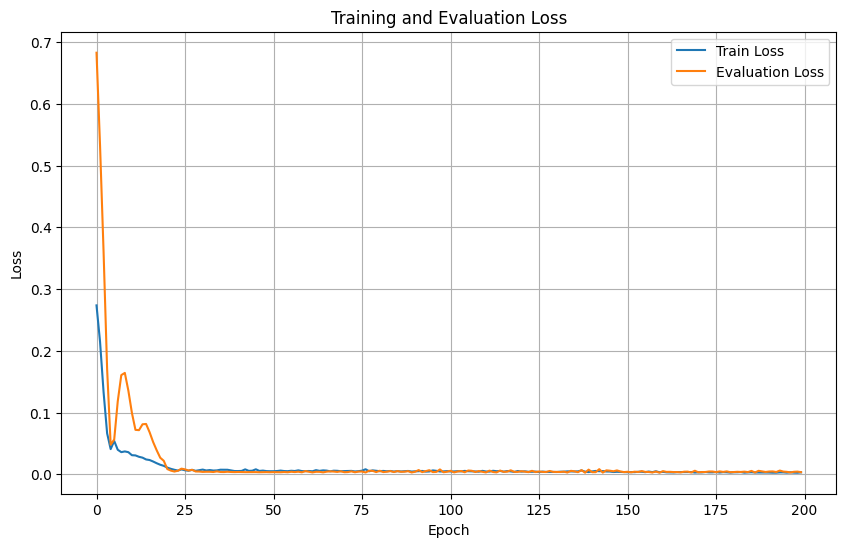

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()